## Importing All Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras_tuner import RandomSearch
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline
import pytz

## Importing Dataset i.e. Nabil Bank (nabil) Stock Price Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/MSc. Dissertation/Dataset/nabil.csv')

In [5]:
df.head()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.0,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.0,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.0,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.0,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.0,352,"393,534.00"


In [6]:
df.tail()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"
3082,9/25/2024,550,560,545.1,555,0.27,"50,441.00","27,867,328.70"


In [7]:
df.duplicated().sum()

1

## Copying the dataset for future use

In [8]:
df1 = df.copy()
df1.reset_index(inplace=True)

### Renaming and Dropping unwanted column

In [9]:
df.drop(['% Change', 'Turnover'], axis=1, inplace=True)
df = df.rename(columns = {
    'Ltp': 'Close',
    'Qty': 'Volume'
})

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float).astype(int)
df

,Date,Open,High,Low,Close,Volume
0,2011-03-20,1200.0,1190.0,1160.0,1170.0,853
1,2011-03-24,1162.0,1178.0,1150.0,1153.0,356
2,2011-03-25,1153.0,1174.0,1145.0,1174.0,702
3,2011-03-27,1174.0,1160.0,1120.0,1147.0,1426
4,2011-03-28,1147.0,1150.0,1110.0,1132.0,352
...,...,...,...,...,...,...
3078,2024-09-18,562.0,565.0,550.0,556.0,68886
3079,2024-09-22,556.0,578.0,556.0,562.0,55026
3080,2024-09-23,573.2,573.2,555.0,568.0,123568
3081,2024-09-24,567.0,567.0,552.1,553.5,66337


### Splitting into features and target

In [11]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [12]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [13]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [14]:
sequence_length = 30
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

### Splitting the data into train and test set

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, y_test_indices = train_test_split(target_index, test_size=0.2, random_state=42)

### Model Building using CNN-LSTM


In [16]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                  hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='mean_squared_error', metrics=['mse', 'mae'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='stock_price_tuning',
    project_name='cnn_stock_price')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Trial 10 Complete [00h 02m 27s]
val_loss: 0.001021119038341567

Best val_loss So Far: 0.0005449056916404516
Total elapsed time: 00h 23m 41s


In [17]:
best_model = tuner.get_best_models(num_models=1)[0]

In [18]:
# Make predictions on the test set
predictions = best_model.predict(X_test)
predictions.flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([0.43030602, 0.66763717, 0.5635642 , 0.67632097, 0.10181297,
       0.34071004, 0.57568467, 0.41604292, 0.62106407, 0.4466455 ,
       0.45509276, 0.07511427, 0.34148607, 0.46194106, 0.6445677 ,
       0.1771335 , 0.80542165, 0.3503738 , 0.19128072, 0.79534286,
       0.1880514 , 0.121792  , 0.5734574 , 0.44893217, 0.7566641 ,
       0.18813598, 0.07535501, 0.23682404, 0.43783608, 0.1311368 ,
       0.914203  , 0.6291144 , 0.18535286, 0.45145696, 0.6269607 ,
       0.23416817, 0.07120145, 0.7891881 , 0.18750238, 0.15212905,
       0.26184624, 0.02887574, 0.4914537 , 0.14781807, 0.01217767,
       0.13558304, 0.34707013, 0.2863269 , 0.348055  , 0.59023815,
       0.18557706, 0.5138941 , 0.44760686, 0.37995738, 0.56289417,
       0.06637371, 0.04028691, 0.38169473, 0.30226824, 0.25911054,
       0.6532354 , 0.6791636 , 0.3325982 , 0.562677  , 0.18751332,
       0.87589616, 0.01823634, 0.06811519, 0.31352335, 0.3845837 ,
       0.6513978 , 0.6135824 , 0.14904597, 0.4447003 , 0.21774

In [19]:
y_test

array([0.45017182, 0.66709622, 0.55841924, 0.70575601, 0.09965636,
       0.3685567 , 0.57689003, 0.43939003, 0.5854811 , 0.45532646,
       0.48281787, 0.07310997, 0.33934708, 0.45446735, 0.67353952,
       0.17310997, 0.79381443, 0.34750859, 0.1911512 , 0.80670103,
       0.1774055 , 0.12628866, 0.5661512 , 0.43685567, 0.73152921,
       0.19802405, 0.09750859, 0.22680412, 0.43513746, 0.14175258,
       0.96993127, 0.62414089, 0.18170103, 0.44158076, 0.62285223,
       0.22379725, 0.08891753, 0.81099656, 0.18213058, 0.14067869,
       0.24699313, 0.0270189 , 0.48883162, 0.14390034, 0.00558419,
       0.12843643, 0.31357388, 0.27405498, 0.36297251, 0.5790378 ,
       0.18427835, 0.53221649, 0.43599656, 0.37457045, 0.54080756,
       0.08118557, 0.04338488, 0.37628866, 0.28264605, 0.24140893,
       0.64561856, 0.64561856, 0.36984536, 0.55541237, 0.19630584,
       0.9871134 , 0.01159794, 0.05992268, 0.29424399, 0.39003436,
       0.66065292, 0.65120275, 0.14304124, 0.43857388, 0.20833

In [20]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [21]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df.index:
        if a == b:
            prediction['Date'] = df['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2011-05-11,1070.0,1045.396240
2011-06-02,1056.0,1140.809082
2011-06-14,868.0,1030.087524
2011-06-26,1228.0,1016.432800
2011-06-27,1106.0,1067.066528
...,...,...
2024-09-01,595.0,634.858643
2024-09-09,573.0,587.417603
2024-09-11,561.5,580.572144


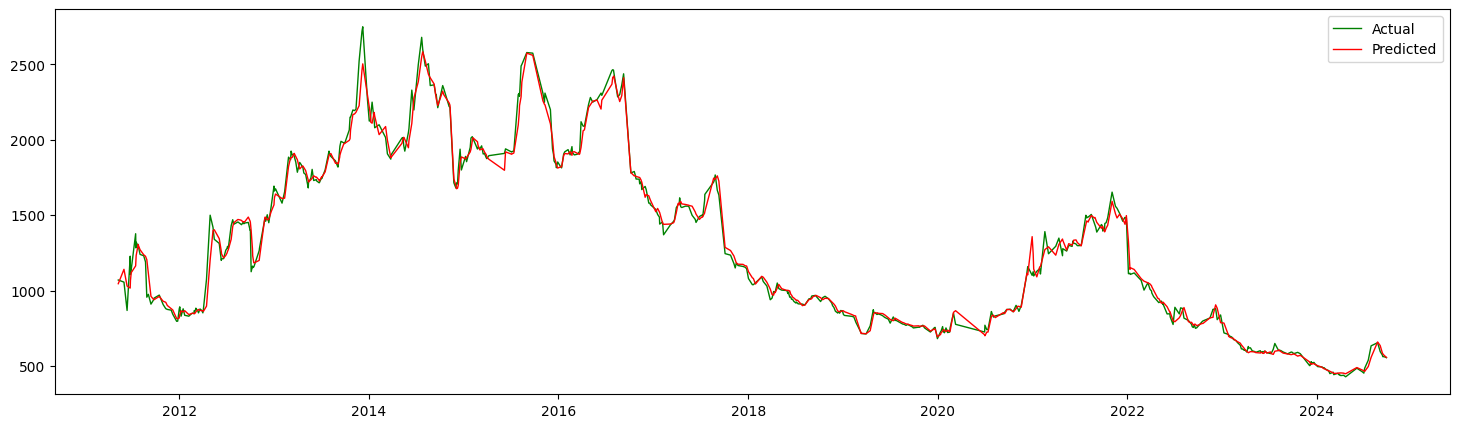

In [22]:
plt.figure(figsize=(18, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.legend()
plt.show()


## Calculating the Performance Evaluation Metrics

In [23]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.0005250990124307078
Root Mean Squared Error: 0.02291503900129144
Mean Absolute Error: 0.01409247833932359


In [24]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 2845.8182619963313
Root Mean Squared Error: 53.346211318108914
Mean Absolute Error: 32.80728597937552
